# New York City Taxi Trip Duration Prediction

Goal is to make a prediction of the duration of a taxi trip based upon individual attributes of a given trip. 



In [1]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [2]:
files = ["green_tripdata_2021-01.parquet", "green_tripdata_2021-02.parquet", 'green_tripdata_2021-03.parquet']

In [24]:
files_yellow = ["yellow_tripdata_2021-01.parquet", "yellow_tripdata_2021-02.parquet", 'yellow_tripdata_2021-03.parquet']

In [25]:
def read_data(files):
    taxi_data =  pd.concat([pd.read_parquet(f) for f in files])
    taxi_data['trip_duration'] = taxi_data['lpep_dropoff_datetime'] - taxi_data['lpep_pickup_datetime']
    taxi_data['trip_duration'] = taxi_data['trip_duration'].dt.total_seconds()
    taxi_data['trip_duration'] = taxi_data['trip_duration'] / 60
    taxi_data = taxi_data[taxi_data['trip_duration'] > 0 & (taxi_data['trip_duration'] < 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    taxi_data[categorical] = taxi_data[categorical].astype(str)
    return taxi_data


def read_data_yellow(files):
    taxi_data =  pd.concat([pd.read_parquet(f) for f in files])
    taxi_data['trip_duration'] = taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']
    taxi_data['trip_duration'] = taxi_data['trip_duration'].dt.total_seconds()
    # taxi_data['trip_duration'] = taxi_data['trip_duration'] / 60
    # taxi_data = taxi_data[taxi_data['trip_duration'] > 0 & (taxi_data['trip_duration'] < 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    taxi_data[categorical] = taxi_data[categorical].astype(str)
    return taxi_data

In [ ]:
files = ['train.csv']
def read_data_kaggle(files):
    taxi_data =  pd.concat([pd.read_csv(f) for f in files])
    taxi_data['trip_duration'] = taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']
    taxi_data['trip_duration'] = taxi_data['trip_duration'].dt.total_seconds()
    # taxi_data['trip_duration'] = taxi_data['trip_duration'] / 60
    # taxi_data = taxi_data[taxi_data['trip_duration'] > 0 & (taxi_data['trip_duration'] < 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    taxi_data[categorical] = taxi_data[categorical].astype(str)
    return taxi_data

In [26]:
taxi_data = read_data(files)

In [27]:
yellow_taxi_data = read_data_yellow(files_yellow)

In [28]:
yellow_taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,2.5,NaN,362.0
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0,NaN,59.0
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,0.0,NaN,1656.0
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.0,0.5,0.5,6.05,0.0,0.3,36.35,0.0,NaN,913.0
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,2.5,NaN,992.0


In [29]:
class DataCleaning:
    def __init__(self, data):
        self.data = data
        
    def dup_and_miss(self):
        print(f"Number of duplicated rows: {self.data.duplicated().sum()}")
        print(f"Number of NA rows: {self.data.isna().sum().sum()}")

    def outlier_removal(self):
        self.data = self.data[(self.data.trip_duration < 5600)]
        self.data = self.data[(self.data.trip_duration > 0)]
        self.data = self.data[(self.data.passenger_count > 0)]

In [30]:
dc = DataCleaning(data=yellow_taxi_data)
dc.dup_and_miss()
dc.outlier_removal()

Number of duplicated rows: 0
Number of NA rows: 5785189


In [54]:
class FeatureEngineering:

    def __init__(self, dc):
        self.data = dc.data
        
    def one_hot(self):
        self.data = pd.concat([self.data, pd.get_dummies(self.data['store_and_fwd_flag'])], axis=1)
        self.data = pd.concat([self.data, pd.get_dummies(self.data['VendorID'])], axis=1)

        self.data.drop(['store_and_fwd_flag'], axis=1, inplace=True)
        self.data.drop(['VendorID'], axis=1, inplace=True)

    def date_features(self):
        self.data['month'] = self.data.tpep_pickup_datetime.dt.month
        self.data['day'] = self.data.tpep_pickup_datetime.dt.day
        self.data['hour'] = self.data.tpep_pickup_datetime.dt.hour
        self.data['minute'] = self.data.tpep_pickup_datetime.dt.minute
        self.data['day_of_week'] = self.data.tpep_pickup_datetime.dt.dayofweek
        # self.data['week'] = self.data.tpep_pickup_datetime.dt.isocalendar().week
        self.data['weekday'] = self.data.tpep_pickup_datetime.dt.weekday
        return self.data.info()

    def drop_cols(self):
        self.data = self.data.drop(['tpep_dropoff_datetime'], axis=1)
        self.data = self.data.drop(['tpep_pickup_datetime'], axis=1)
        self.data = self.data.drop(['DOLocationID'], axis=1)
        self.data = self.data.drop(['PULocationID'], axis=1)
        self.data = self.data.drop(['airport_fee'], axis=1)
        self.data = self.data.drop(['RatecodeID'], axis=1)
        self.data = self.data.drop(['congestion_surcharge'], axis=1)
        self.data = self.data.drop(['passenger_count'], axis=1)


    

In [55]:
fe = FeatureEngineering(dc)
fe.one_hot()
fe.date_features()
fe.drop_cols()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4237075 entries, 0 to 1797231
Data columns (total 28 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        float64       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           object        
 6   DOLocationID           object        
 7   payment_type           int64         
 8   fare_amount            float64       
 9   extra                  float64       
 10  mta_tax                float64       
 11  tip_amount             float64       
 12  tolls_amount           float64       
 13  improvement_surcharge  float64       
 14  total_amount           float64       
 15  congestion_surcharge   float64       
 16  airport_fee            float64       
 17  trip_duration          float64       
 18  N                     

In [39]:
from sklearn.model_selection import train_test_split


class Model:

    def __init__(self, fe):
        self.data = fe.data

    def train_test_split(self):
        y = self.data['trip_duration']
        X = self.data.drop(['trip_duration'], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test

    def random_forest(self):
        from sklearn.ensemble import RandomForestRegressor
        rf = RandomForestRegressor()
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        print(f"Random Forest RMSE: {mean_squared_error(y_test, y_pred, squared=False)}")

    def light_gbm(self):
        from sklearn.metrics import mean_squared_error as MSE
        import lightgbm as lgb
        from lightgbm import LGBMRegressor
        import numpy as np
        lgbm = lgb.LGBMRegressor()
        lgbm.fit(X_train, y_train)
        print(lgbm.score(X_train, y_train), lgbm.score(X_test, y_test))
        print(f"MSE: {np.sqrt(MSE(y_test, lgbm.predict(X_test)))}")
        lgbm.predict

    def lrrr(self):
        from sklearn.linear_model import LinearRegression
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        print(lr.score(X_train, y_train), lr.score(X_test, y_test))
        print(f"Linear Regression RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared=False)}")

    


In [40]:
model = Model(fe)

X_train, X_test, y_train, y_test = model.train_test_split()
model.light_gbm()

0.9458338539445784 0.9460787693067035
MSE: 119.60956680938989


In [42]:
model.lrrr()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

light_gbm mse: 3432.0272461961777
LR mse: 3464.5318724459717

In [ ]:
model.data.head()

,trip_distance,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,...,store_and_fwd_flag_Y,VendorID_1,VendorID_2,month,day,hour,minute,day_of_week,week,weekday
0,2.10,2,8.0,3.0,0.5,0.00,0.0,0.3,11.80,362.0,...,NaN,NaN,NaN,1,1,0,30,4,53,4
1,0.20,2,3.0,0.5,0.5,0.00,0.0,0.3,4.30,59.0,...,NaN,NaN,NaN,1,1,0,51,4,53,4
2,14.70,1,42.0,0.5,0.5,8.65,0.0,0.3,51.95,1656.0,...,NaN,NaN,NaN,1,1,0,43,4,53,4
4,4.94,1,16.5,0.5,0.5,4.06,0.0,0.3,24.36,992.0,...,NaN,NaN,NaN,1,1,0,31,4,53,4
5,1.60,1,8.0,3.0,0.5,2.35,0.0,0.3,14.15,481.0,...,NaN,NaN,NaN,1,1,0,16,4,53,4


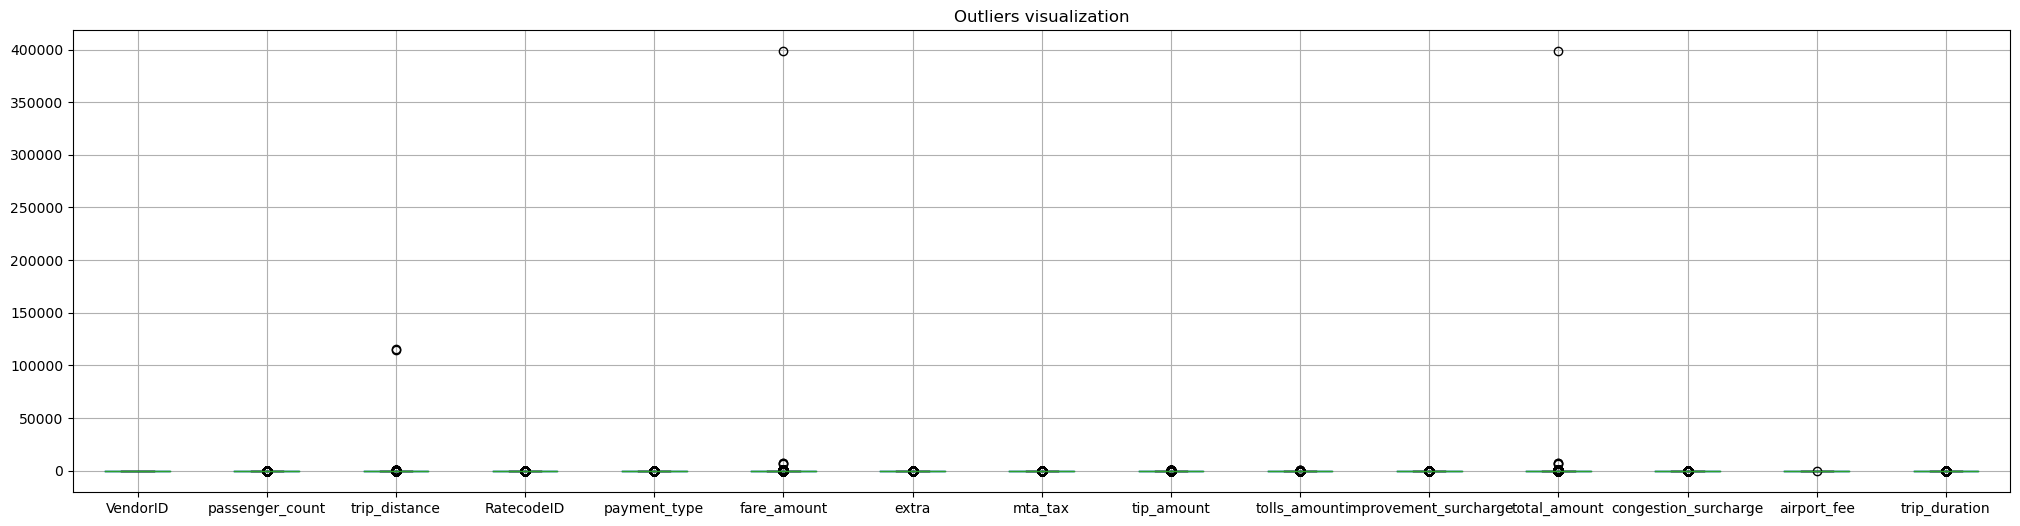

In [280]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(25,6))
plt.title("Outliers visualization")
dc.data.boxplot();

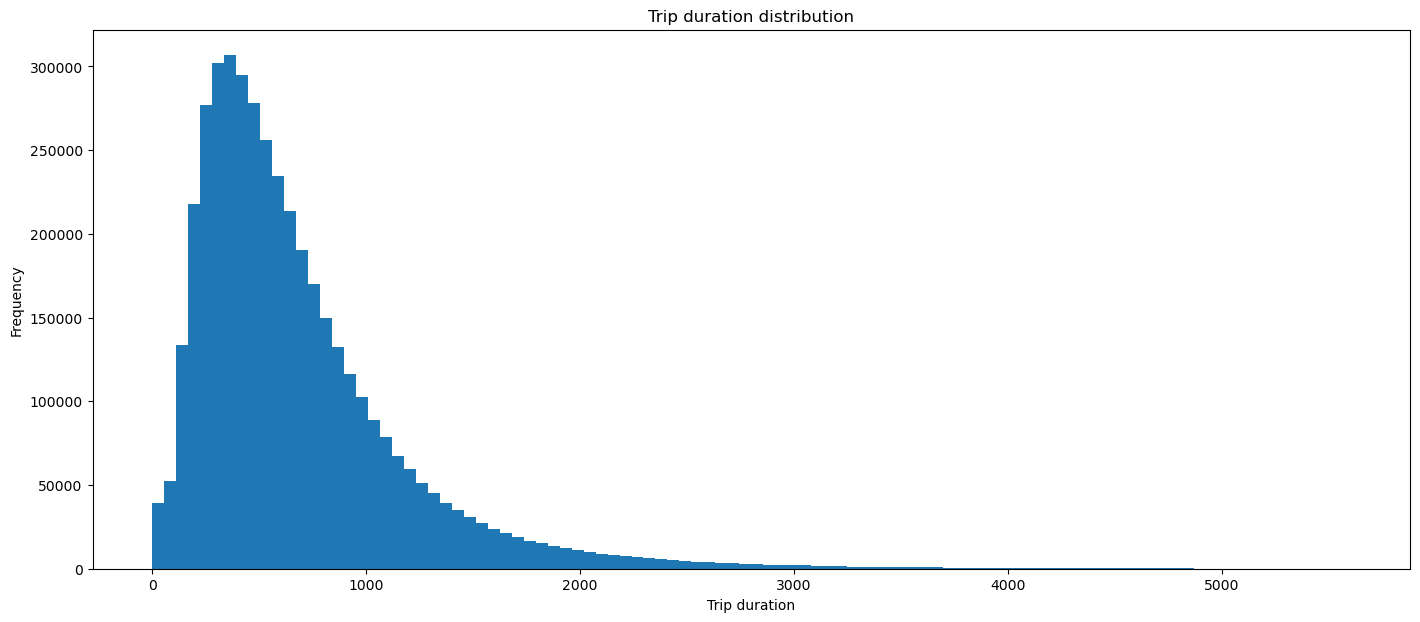

In [160]:
plt.subplots(figsize=(17,7))
plt.hist(dc.data['trip_duration'].values, bins=100)
plt.title("Trip duration distribution")
plt.xlabel("Trip duration")
plt.ylabel("Frequency")
plt.show()


The data for the trip duration is skewed to the right, so we will use the log of the trip duration as the target variable. This transformation is visualised in the cell below. 

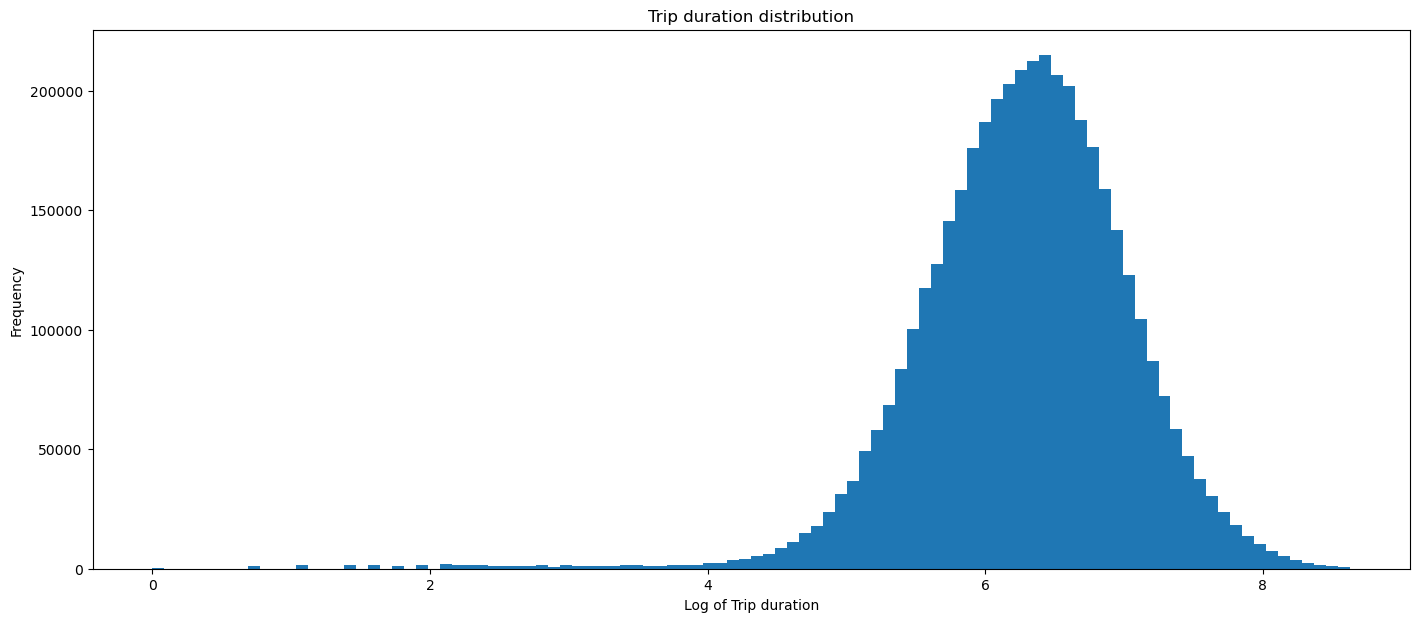

In [164]:
import numpy as np

plt.subplots(figsize=(17,7))
dc.data['trip_duration'] = np.log(dc.data['trip_duration'].values)
plt.hist(dc.data['trip_duration'].values, bins=100)
plt.title("Trip duration distribution")
plt.xlabel("Log of Trip duration")
plt.ylabel("Frequency")
plt.show()

In [6]:
def parition_data(taxi_data):
    jan_taxi_data = taxi_data[taxi_data['lpep_pickup_datetime'].dt.month == 1]
    feb_taxi_data = taxi_data[taxi_data['lpep_pickup_datetime'].dt.month == 2]
    mar_taxi_data = taxi_data[taxi_data['lpep_pickup_datetime'].dt.month == 3]
    return jan_taxi_data, feb_taxi_data, mar_taxi_data


jan_taxi_data, feb_taxi_data, mar_taxi_data = parition_data(taxi_data)

# # select rows where month is 1
# jan_taxi_data = taxi_data[taxi_data['lpep_pickup_datetime'].dt.month == 1]

# # select rows where month is 2
# feb_taxi_data = taxi_data[taxi_data['lpep_pickup_datetime'].dt.month == 2]


In [39]:
class Model:
    def __init__(self, data, model, features, target):
        self.data = data
        self.model = model
        self.features = features
        self.target = target
        self.X = None
        self.y = None
        self.predictions = None
        self.mse = None
        self.r2 = None
        self.coef = None
        self.intercept = None

    def train_test_split(self):
        self.X = self.data[self.features]
        self.y = self.data[self.target]

    def preprocess(self):
        self.X = self.X.to_numpy()
        self.y = self.y.to_numpy()

    def fit(self):
        self.model.fit(self.X, self.y)

    def predict(self):
        self.predictions = self.model.predict(self.X)

    def evaluate(self):
        self.mse = mean_squared_error(self.y, self.predictions)
        self.r2 = self.model.score(self.X, self.y)
        self.coef = self.model.coef_
        self.intercept = self.model.intercept_

    def run(self):
        self.train_test_split()
        self.preprocess()
        self.fit()
        self.predict()
        self.evaluate()

        

In [45]:
taxi_LR = Model(taxi_data, LinearRegression(), ['trip_distance'], 'trip_duration')

print(taxi_LR)


In [55]:
from sklearn.model_selection import train_test_split
lr = LinearRegression()

def split_data(data, features, target):
    X = data[features]
    y = data[target]
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = split_data(taxi_data, ['trip_distance'], 'trip_duration')

def train_model(X_train, y_train, model):
    model.fit(X_train, y_train)
    return model

lr = train_model(X_train, y_train, lr)

def predict(X_test, model):
    return model.predict(X_test)

predictions = predict(X_test, lr)

def evaluate(y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    r2 = lr.score(X_test, y_test)
    return mse, r2

mse, r2 = evaluate(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")







Mean Squared Error: 3451.1450718946535
R2 Score: -2.689297441205163e-05


In [60]:
df_train = pd.concat([jan_taxi_data, feb_taxi_data])
df_val = mar_taxi_data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667
5,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,52.00,...,0.5,0.00,0.0,None,0.3,52.80,2.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,2,2021-02-28 22:19:00,2021-02-28 22:29:00,None,NaN,129,7,NaN,2.63,10.04,...,0.0,0.00,0.0,None,0.3,10.34,NaN,NaN,NaN,10.000000
64568,2,2021-02-28 23:18:00,2021-02-28 23:27:00,None,NaN,116,166,NaN,1.87,8.33,...,0.0,1.89,0.0,None,0.3,10.52,NaN,NaN,NaN,9.000000
64569,2,2021-02-28 23:44:00,2021-02-28 23:58:00,None,NaN,74,151,NaN,2.40,12.61,...,0.0,0.00,0.0,None,0.3,12.91,NaN,NaN,NaN,14.000000
64570,2,2021-02-28 23:07:00,2021-02-28 23:14:00,None,NaN,42,42,NaN,1.11,11.95,...,0.0,0.00,0.0,None,0.3,15.00,NaN,NaN,NaN,7.000000


In [61]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

C:\Users\rhys-\AppData\Local\Temp\ipykernel_18804\652578202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']


In [62]:
categorical = ['PU_DO']
numerical = ['trip_distance']
dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [63]:
target = 'trip_duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [64]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)

In [65]:
rmse

55.03652577663828

c:\Users\rhys-\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\rhys-\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


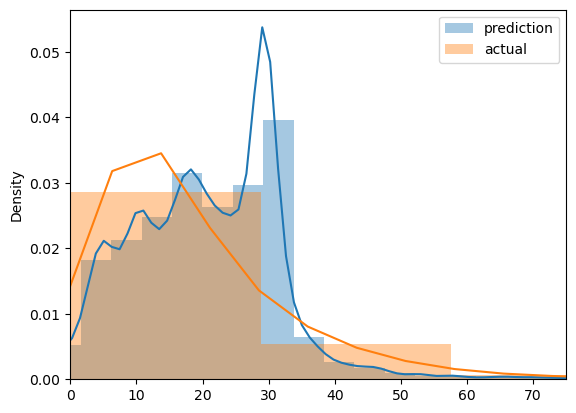

In [66]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.xlim(0, 75)

plt.legend()